### Try the network sampler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_coloc.continuous_donut_interaction import DonutInteraction
from bayes_coloc.plot_matching_lines import plot_pair_prob
from scipy.special import gammaln


%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(0)

d = 2

# set parameters
area = 1
scale = 0.005
radius = 0.01
gamma = 750
alpha = 250# np.e**-20
beta = 250# np.e**-20
true_params = {'gamma': gamma, 'alpha': alpha, 'beta': beta,
    'scale': scale, 'radius': radius, 'area': area}

### Data generation 

n_gamma = np.random.poisson(lam=true_params['gamma']*area)
n_mu = np.random.poisson(lam=true_params['alpha']*area)
n_nu = np.random.poisson(lam=true_params['beta']*area)

# Sample points in space 
hatmu = np.random.random(size=(n_mu, d)) 
hatnu = np.random.random(size=(n_nu, d)) 
hatgamma_x = np.random.random(size=(n_gamma, d))
random_angles = 2*np.pi*np.random.random(size=n_gamma)
random_directions = np.vstack((np.cos(random_angles), np.sin(random_angles))).T
random_shift = random_directions * radius
hatgamma_y = hatgamma_x + np.random.normal(scale=scale, size=(n_gamma, d)) + random_shift

# Merge marginals
x = np.vstack((hatgamma_x, hatmu))
y = np.vstack((hatgamma_y, hatnu))

nx, ny = len(x), len(y)

# now shuffle the data
perm_x = np.random.permutation(nx)
perm_y = np.random.permutation(ny)
x = x[perm_x]
y = y[perm_y]

# COMPUTE (TRUE) MATCHING
unpermuted_matching_mat = np.zeros((nx, ny))
unpermuted_matching_mat[range(n_gamma), range(n_gamma)] = 1
matching_mat = unpermuted_matching_mat[:, perm_y]
matching_mat = matching_mat[perm_x, :]



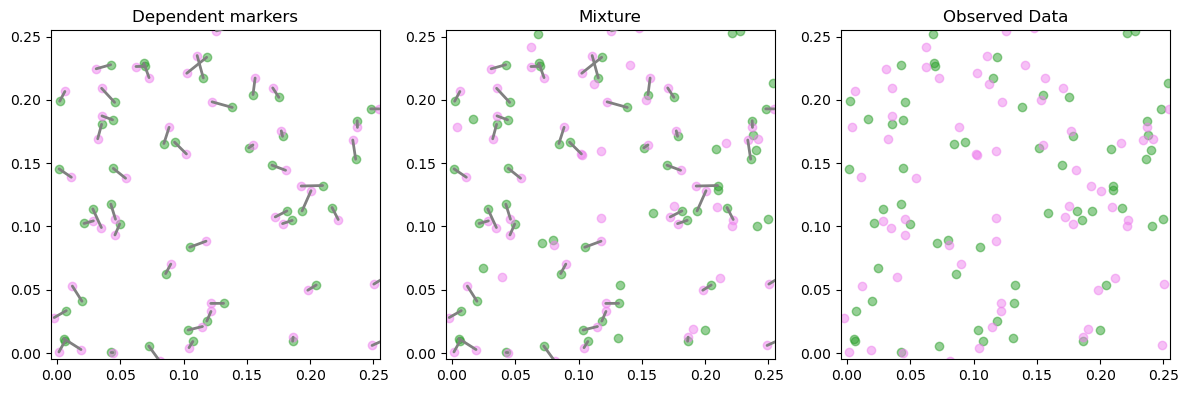

In [4]:
fig, axis = plt.subplots(ncols=3, figsize=(12, 4))
marker = "o"
alpha = 0.5
linewidth = 2
plan = np.eye(len(hatgamma_y))
plot_pair_prob(hatgamma_x, hatgamma_y, plan, l=linewidth, 
               ax=axis[0], scatter_alpha=alpha)
axis[0].set_aspect("equal")
h = 0.005

axis[0].set_title("Dependent markers")
axis[1].set_title("Mixture")
axis[2].set_title("Observed Data")

for ax in axis:
    ax.set_aspect("equal")
    ax.set_xlim(-h, np.sqrt(area)/4+h)
    ax.set_ylim(-h, np.sqrt(area)/4+h)
    # remove ticks
    # ax.set_xticks([])
    # ax.set_yticks([])
    
plot_pair_prob(x, y, matching_mat, ax=axis[1], l=linewidth, scatter_alpha=alpha)
no_matching = np.zeros((nx, ny))
plot_pair_prob(x, y, no_matching, ax=axis[2], l=linewidth, scatter_alpha=alpha)
axis[1].set_title("Mixture")
axis[2].set_title("Observed Data")

# thight layout
plt.tight_layout()
plt.savefig("setup_plot_v2.pdf")
plt.show()


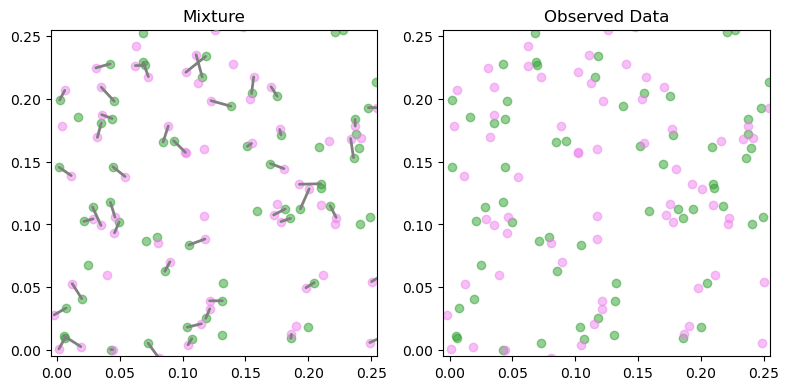

In [5]:
fig, axis = plt.subplots(ncols=2, figsize=(8, 4))
marker = "o"
alpha = 0.5
linewidth = 2
plan = np.eye(len(hatgamma_y))

axis[0].set_aspect("equal")
h = 0.005

axis[0].set_title("Dependent markers")
axis[1].set_title("Data")


for ax in axis:
    ax.set_aspect("equal")
    ax.set_xlim(-h, np.sqrt(area)/4+h)
    ax.set_ylim(-h, np.sqrt(area)/4+h)
    # remove ticks
    # ax.set_xticks([])
    # ax.set_yticks([])
    
plot_pair_prob(x, y, matching_mat, ax=axis[0], l=linewidth, scatter_alpha=alpha)
no_matching = np.zeros((nx, ny))
plot_pair_prob(x, y, no_matching, ax=axis[1], l=linewidth, scatter_alpha=alpha)
axis[0].set_title("Mixture")
axis[1].set_title("Observed Data")

# thight layout
plt.tight_layout()
plt.savefig("setup_plot.pdf")
plt.show()


In [6]:
# print relevant data
print("gamma: ", true_params['gamma'], "alpha: ", true_params['alpha'], "beta: ", true_params['beta'])
print("Number of pairs: ", n_gamma, "Number of single A: ", n_mu, "Number of single B: ", n_nu)
print("Number of points in x: ", nx, "Number of points in y: ", ny)
print("Standard deviation", scale)
print("Radius: ", radius)

gamma:  750 alpha:  250 beta:  250
Number of pairs:  754 Number of single A:  255 Number of single B:  246
Number of points in x:  1009 Number of points in y:  1000
Standard deviation 0.005
Radius:  0.01


In [7]:
# define proposal, prior and starting parameters
scale_interval = [0., 0.02]
radius_interval = [0, 0.02]

area = 1
hyper_theta = len(x)/2

def log_prior(params):
    """ Defines a log prior for the parameters of the model (up to a constant)"""
    
    alpha = params["alpha"]
    gamma = params['gamma']
    beta = params["beta"]
    radius = params['radius']
    scale = params['scale']
    
    # hyperparameters
    k = 1
    theta = hyper_theta
    def ld_gamma(x, k, theta):  
        a = k
        b = 1/theta
        if x <= 0:
            return -np.inf
        else:
            return a*np.log(b) - gammaln(a) + (a-1)*np.log(x) - b*x

    # check if lam parameters are valid
    log_prob = 0
    
    log_prob += ld_gamma(alpha, k, theta)
    log_prob += ld_gamma(gamma, k, theta)
    log_prob += ld_gamma(beta, k, theta)
    
    if scale_interval[0] < scale < scale_interval[1]:
        log_prob += 0
    else:
        log_prob = -np.inf
    if radius_interval[0] < radius < radius_interval[1]:
        log_prob += 0
    else:
        log_prob = -np.inf
    return log_prob

def proposal(params):
    """ Defines a proposal for the parameters of the model """
    scale_temp = 0.001
    radius_temp = 0.001
    intensity_temp = 2
    
    scale = params['scale']
    radius = params['radius']
    alpha = params["alpha"]
    beta = params["beta"]
    gamma = params['gamma']
    
    # new proposal for the scale
    scale_new = scale + np.random.normal(scale=scale_temp)
    new_radius = radius + np.random.normal(scale=radius_temp)
    
    # new proposal for the intensities
    alpha_new = alpha + np.random.normal(scale=intensity_temp)
    beta_new = beta + np.random.normal(scale=intensity_temp)
    gamma_new = gamma + np.random.normal(scale=intensity_temp)
    
    return {"alpha": alpha_new, "beta": beta_new, "gamma": gamma_new, "scale": scale_new, "radius": new_radius, "area": area}



In [8]:
start_params = {"alpha": hyper_theta, "beta": hyper_theta, "gamma": hyper_theta,
                "scale": 0.015, "radius": 0.005, "area": area}

swap_params = start_params.copy()
swap_params["scale"] = 0.02
swap_params["radius"] = 0.002
# start_params = true_params.copy()
# swap_params = start_params.copy()

np.random.seed(0)
chain = DonutInteraction(x, y,start_params, swap_params, log_prior, proposal)

In [9]:
log_probs_fast = chain.latent_state.log_prob_marginal()
log_probs_slow = chain.latent_state.log_prob_marginal_slow() 
# print diff

print("diff", np.sum(np.abs(log_probs_slow - log_probs_fast)))

diff 2.2360412132993446e-13


In [ ]:
chain.run(n_samples=1000000, burn_in=0)


Burn-in period: 0it [00:00, ?it/s]
Sampling:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sampling:  12%|█▏        | 120426/1000000 [17:39<2:15:31, 108.17it/s]

In [10]:
log_probs_fast = chain.latent_state.log_prob_marginal()
log_probs_slow = chain.latent_state.log_prob_marginal_slow() 
# print diff

print("diff", np.sum(np.abs(log_probs_slow - log_probs_fast)))

diff 6.843622890606582e-13


In [1]:
print("chain acceptance rate", chain.latent_acceptance_rate)
print("param acceptance rate", chain.param_acceptance_rate)


NameError: name 'chain' is not defined

In [12]:
print(len(x), len(y), n_gamma)
print(n_gamma, n_mu, n_nu)

1009 1000 754
754 255 246


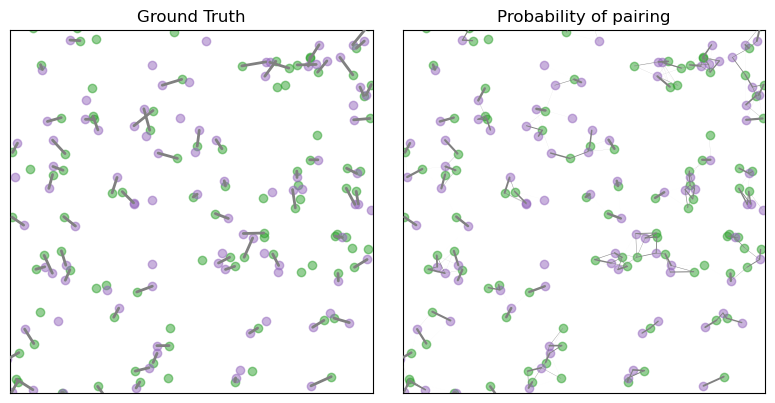

In [13]:
fig, axis = plt.subplots(ncols=2, figsize=(8, 4))
marker = "o"
alpha = 0.5
linewidth = 2
plan = np.eye(len(hatgamma_y))
axis[0].set_aspect("equal")
h = 0.05


for ax in axis:
    ax.set_aspect("equal")
    ax.set_xlim(0, np.sqrt(area)/4+h)
    ax.set_ylim(0, np.sqrt(area)/4+h)
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
plot_pair_prob(x, y, matching_mat, ax=axis[0], l=linewidth, scatter_alpha=alpha)
no_matching = np.zeros((nx, ny))
plot_pair_prob(x, y, chain.pairing_probabilities(), ax=axis[1], l=linewidth, scatter_alpha=alpha)
axis[0].set_title("Ground Truth")
axis[1].set_title("Probability of pairing")
# thight layout
plt.tight_layout()
# plt.savefig("setup_plot_v2.pdf")
plt.show()


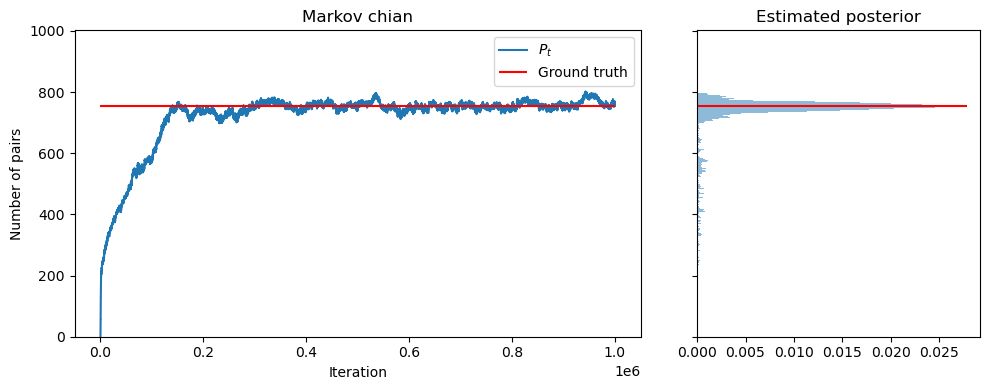

In [24]:
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
# set title of the plot 
# fig.suptitle("Number of co-localized markers")# , fontsize=16)
nx = len(x)
ny = len(y)
n_max = np.minimum(nx, ny)


ax[1].set_visible(False)

pair_count = chain.pair_count_trajectory
ax[0].plot(np.arange(len(pair_count)), pair_count, label="$P_t$")
ax[0].set_ylim((0, n_max+2))
ax[0].hlines(y=n_gamma, xmin=0, xmax=len(pair_count), color="red", label="Ground truth")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Number of pairs")
ax[0].legend()
ax[0].set_title("Markov chian")
bins = np.arange(n_max+2)-0.5
ax[2].hist(chain.pair_count_trajectory, bins=bins, alpha=0.5, label="MCMC", 
           orientation="horizontal", color="tab:blue", density=True)
xmax = np.max(np.histogram(pair_count, bins=bins, density=True)[0])
ax[2].hlines(y=n_gamma, xmin=0, xmax=xmax, color="red")
ax[2].set_ylim((0, n_max+2))
ax[2].set_yticklabels([])
ax[2].set_title("Estimated posterior")
plt.tight_layout()
plt.savefig("pair_count.png", dpi=400)
plt.show()



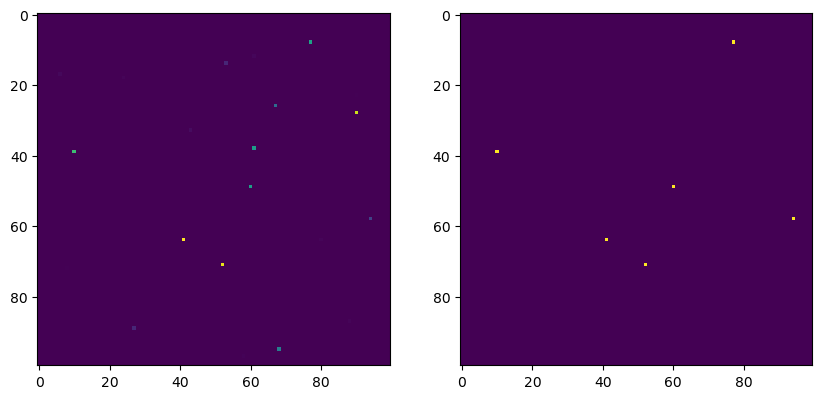

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(chain.pairing_probabilities()[0:100, 0:100])
ax[1].imshow(matching_mat[0:100, 0:100])

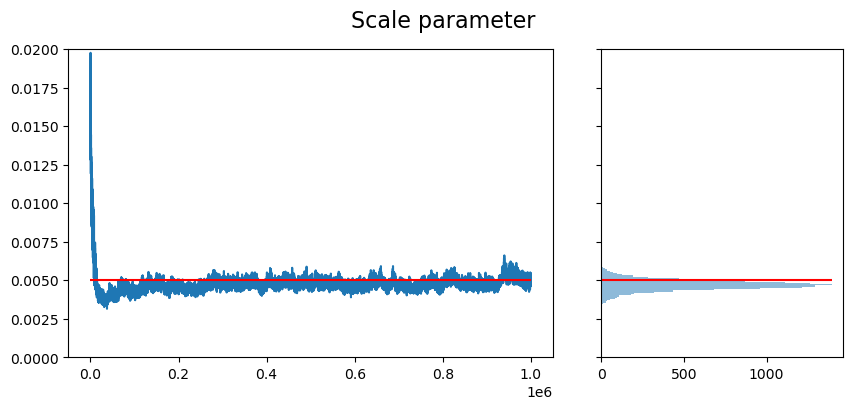

In [18]:
# scale parameter
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
fig.suptitle("Scale parameter", fontsize=16)
ax[0].set_ylim(scale_interval)
ax[1].set_visible(False)

scale_trajectory = [params["scale"] for params in chain.param_trajectory]
ax[0].plot(np.arange(len(scale_trajectory)), scale_trajectory)
ax[0].hlines(y=true_params["scale"], xmin=0, xmax=len(scale_trajectory), color="red")

bins = np.linspace(scale_interval[0], scale_interval[1], 250)
ax[2].hist(scale_trajectory, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(scale_trajectory, bins=bins, density=True)[0])
ax[2].hlines(y=true_params["scale"], xmin=0, xmax=xmax, color="red")
ax[2].set_ylim(scale_interval)
ax[2].set_yticklabels([])
plt.show()



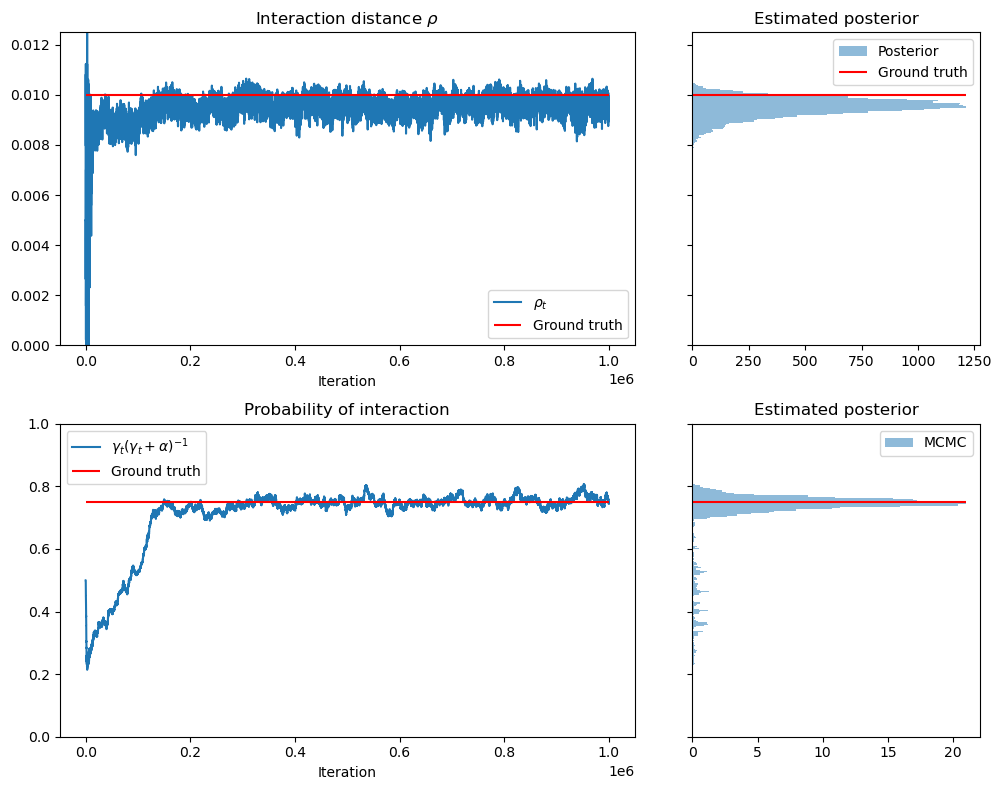

In [ ]:
# do plot for radius 
radius_interval = [0, 0.0125]
# do plot for radius parameter
# ripley_dist = 2.04
# soda_dist = 2.4
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=2, ncols=3, gridspec_kw=gridspec, figsize=(10, 8))
# fig.suptitle("Co-localization distance")# , fontsize=16)
ax[0, 0].set_ylim(radius_interval)
ax[0, 1].set_visible(False)

radius_trajectory = [params["radius"] for params in chain.param_trajectory]
ax[0, 0].plot(np.arange(len(radius_trajectory)), radius_trajectory, label=r'$\rho_t$')
ax[0, 0].set_xlabel("Iteration")
ax[0, 0].hlines(y=true_params["radius"], xmin=0, xmax=len(radius_trajectory), color="red", label="Ground truth")
# ax[0, 0].hlines(y=ripley_val_radius, xmin=0, xmax=len(radius_trajectory), color="red", label="Ripley value")
ax[0, 0].legend()
ax[0, 0].set_title(r'Interaction distance $\rho$')

bins = np.linspace(radius_interval[0], radius_interval[1], 250)
ax[0, 2].set_title("Estimated posterior")
ax[0, 2].hist(radius_trajectory, bins=bins, alpha=0.5, label="Posterior", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(radius_trajectory, bins=bins, density=True)[0])
# ax[1, 2].hlines(y=ripley_dist, xmin=0, xmax=xmax, color="orange", label="Ripley's K")
# ax[1, 2].hlines(y=soda_dist, xmin=0, xmax=xmax, color="green", label="SODA")
ax[0, 2].hlines(y=true_params["radius"], xmin=0, xmax=xmax, color="red", label="Ground truth")
ax[0, 2].set_ylim(radius_interval)
ax[0, 2].set_yticklabels([])
ax[0, 2].legend()


ax[1, 0].set_ylim((0, 1))
ax[1, 0].set_title("Probability of interaction")
ax[1, 0].set_xlabel("Iteration")

ax[1, 1].set_visible(False)
p_a_pair_traj = [params["gamma"]/(params["gamma"]+params["alpha"]) for params in chain.param_trajectory]
p_a_pair_true = true_params["gamma"]/(true_params["gamma"] + true_params["alpha"])
ax[1, 0].plot(np.arange(len(p_a_pair_traj)), p_a_pair_traj, label=r'$\gamma_t(\gamma_t + \alpha)^{-1}$')
ax[1, 0].hlines(y=p_a_pair_true, xmin=0, xmax=len(p_a_pair_traj), color="red", label="Ground truth")
ax[1, 0].legend()
bins = np.linspace(0, 1, 250)
ax[1, 2].hist(p_a_pair_traj, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(p_a_pair_traj, bins=bins, density=True)[0])
# ax[1, 2].hlines(y=ripley_percent, xmin=0, xmax=xmax, color="orange", label="Ripley's K")
# ax[1, 2].hlines(y=soda_percent, xmin=0, xmax=xmax, color="green", label="SODA")

ax[1, 2].hlines(y=p_a_pair_true, xmin=0, xmax=xmax, color="red", label="Ground truth")
ax[1, 2].set_ylim((0, 1))
ax[1, 2].set_title("Estimated posterior")

ax[1, 2].set_yticklabels([])
ax[1, 2].legend()
plt.tight_layout()
plt.savefig("param result.png", dpi=400)
plt.show()


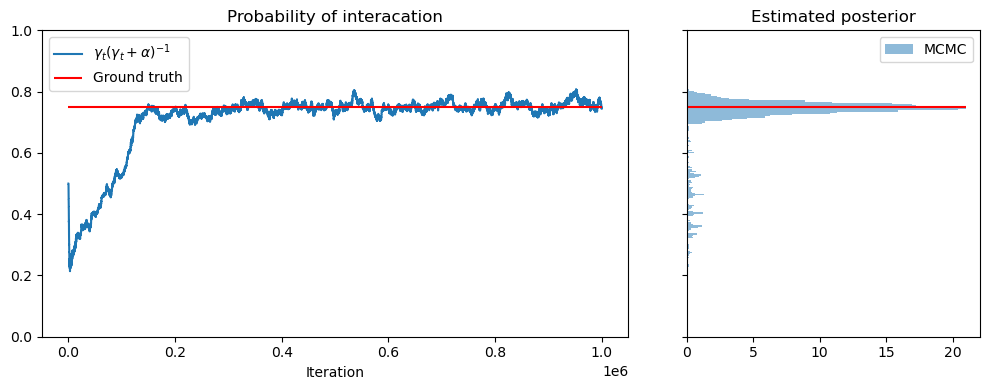

In [32]:
# probability of pairing in the second channel
# ripley_percent = 0.29
# soda_percent = 0.36
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
# fig.suptitle("Percentage of co-localized markers in channel 2")# , fontsize=16)
ax[0].set_ylim((0, 1))
ax[0].set_title("Probability of interacation")
ax[0].set_xlabel("Iteration")

ax[1].set_visible(False)
p_a_pair_traj = [params["gamma"]/(params["gamma"]+params["alpha"]) for params in chain.param_trajectory]
p_a_pair_true = true_params["gamma"]/(true_params["gamma"] + true_params["alpha"])
ax[0].plot(np.arange(len(p_a_pair_traj)), p_a_pair_traj, label=r'$\gamma_t(\gamma_t + \alpha)^{-1}$')
ax[0].hlines(y=p_a_pair_true, xmin=0, xmax=len(p_a_pair_traj), color="red", label="Ground truth")
ax[0].legend()
bins = np.linspace(0, 1, 250)
ax[2].hist(p_a_pair_traj, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(p_a_pair_traj, bins=bins, density=True)[0])
# ax[2].hlines(y=ripley_percent, xmin=0, xmax=xmax, color="orange", label="Ripley's K")
# ax[2].hlines(y=soda_percent, xmin=0, xmax=xmax, color="green", label="SODA")

ax[2].hlines(y=p_a_pair_true, xmin=0, xmax=xmax, color="red")
ax[2].set_ylim((0, 1))
ax[2].set_title("Estimated posterior")

ax[2].set_yticklabels([])
ax[2].legend()
plt.tight_layout()
plt.savefig("plot_intensity_ratio.png", dpi=400)
plt.show()



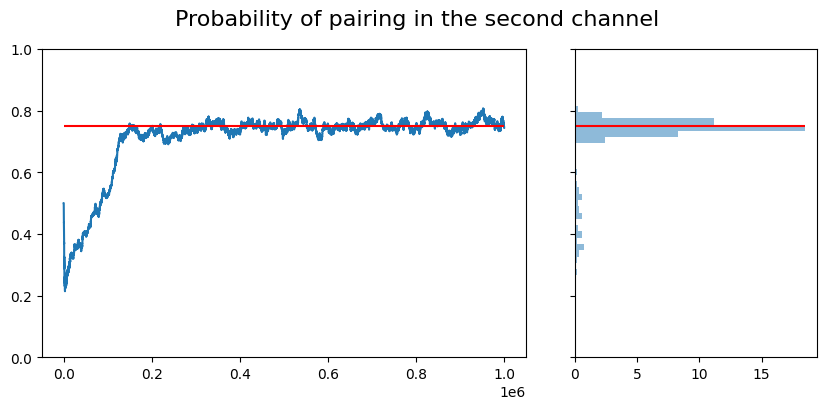

In [20]:
# probability of pairing in the second channel
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
fig.suptitle("Probability of pairing in the second channel", fontsize=16)
ax[0].set_ylim((0, 1))

ax[1].set_visible(False)
p_b_pair_traj = [params["gamma"]/(params["gamma"]+params["alpha"]) for params in chain.param_trajectory]
p_b_pair_true = true_params["gamma"]/(true_params["gamma"] + true_params["alpha"])
ax[0].plot(np.arange(len(p_b_pair_traj)), p_b_pair_traj)
ax[0].hlines(y=p_b_pair_true, xmin=0, xmax=len(p_b_pair_traj), color="red")

bins = np.linspace(0, 1, 50)
ax[2].hist(p_b_pair_traj, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(p_b_pair_traj, bins=bins, density=True)[0])
ax[2].hlines(y=p_b_pair_true, xmin=0, xmax=xmax, color="red")
ax[2].set_ylim((0, 1))

ax[2].set_yticklabels([])
plt.show()



In [21]:
log_probs_fast = chain.latent_state.log_prob_marginal()
log_probs_slow = chain.latent_state.log_prob_marginal_slow() 
# print diff

real_values = np.logical_and(log_probs_fast > -np.inf, log_probs_slow > -np.inf)

log_probs_fast = log_probs_fast[real_values]
log_probs_slow = log_probs_slow[real_values]
print("diff", np.sum( log_probs_slow - log_probs_fast))


diff -1.417754802446325e-13


In [22]:
print("diff",  log_probs_slow - log_probs_fast)

diff [ 0.00000000e+00  6.66133815e-16  0.00000000e+00 ...  2.22044605e-16
 -2.22044605e-16 -4.44089210e-16]
